<a href="https://colab.research.google.com/github/Randolpnshi/test/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background
In this project, I used he dataset consists of 13,403 full slide images of breast cancer specimens scanned at 40X(the dataset would be included in the upload file)\
The main goal is to use these labeled images buliding a network can identify breast cancer accurately.


In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
# Set up GPU
if gpus:
    gpu0 = gpus[0] #if there is mutiple cores, choose core[0]
    tf.config.experimental.set_memory_growth(gpu0, True) 
    tf.config.set_visible_devices([gpu0],"GPU")
    
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings("ignore")             
plt.rcParams['axes.unicode_minus'] = False  # use it to show negative sign

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib

data_dir = "/content/drive/MyDrive/Colab Notebooks/Project"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("Total image count：",image_count)

Total image count： 13403


In [ ]:
batch_size = 16
img_height = 50
img_width  = 50

In [ ]:
# return tf.data.Dataset acording to different folders
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 13403 files belonging to 2 classes.
Using 10723 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 13403 files belonging to 2 classes.
Using 2680 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


In [ ]:
# check the image properties
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 50, 50, 3)
(16,)


#Dataset configuration 
1. shuffle(): shuffle the data 
2. prefecth(): speed up the process
3. cache(): put dataset into cache to speed up

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image,label):
    return (image/255.0,label)

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)    # in which we can set the preprocessing parameters
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)    # in which we can set the preprocessing parameters
    .prefetch(buffer_size=AUTOTUNE)
)

#Data Visualiztion

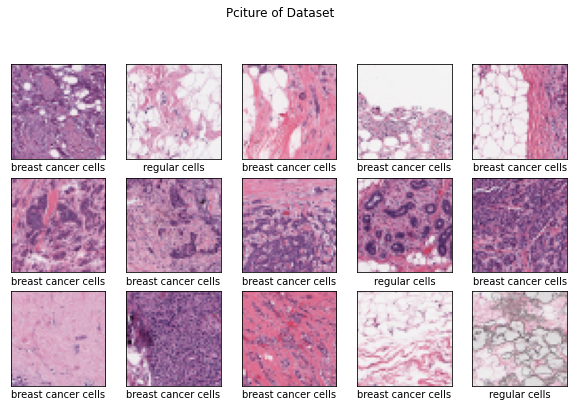

In [ ]:
plt.figure(figsize=(10, 8))  
plt.suptitle("Pciture of Dataset")

class_names = ["breast cancer cells","regular cells"]

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # show the image
        plt.imshow(images[i])
        # show the label
        plt.xlabel(class_names[labels[i]-1])

plt.show()

#Learning Model

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu",input_shape=[img_width, img_height, 3]),
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu"),

    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                    

In [ ]:
model.compile(optimizer="adam",
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 100
PATIENCE  = 5
VERBOSE   = 1

# set up dynamic learning rate
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

# set up early-stopping
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

# 
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [ ]:
train_model  = model.fit(train_ds,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/100
671/671 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7236
Epoch 1: val_accuracy improved from -inf to 0.82463, saving model to best_model.h5
671/671 [==============================] - 253s 376ms/step - loss: 0.5386 - accuracy: 0.7236 - val_loss: 0.4301 - val_accuracy: 0.8246 - lr: 3.6603e-04
Epoch 2/100
671/671 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8076
Epoch 2: val_accuracy did not improve from 0.82463
671/671 [==============================] - 59s 89ms/step - loss: 0.4406 - accuracy: 0.8076 - val_loss: 0.4035 - val_accuracy: 0.8216 - lr: 3.6237e-04
Epoch 3/100
671/671 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8188
Epoch 3: val_accuracy improved from 0.82463 to 0.83321, saving model to best_model.h5
671/671 [==============================] - 60s 89ms/step - loss: 0.4147 - accuracy: 0.8188 - val_loss: 0.4043 - val_accuracy: 0.8332 - lr: 3.5875e-04
Epoch 4/100
671/671 [================

#Evaluation 

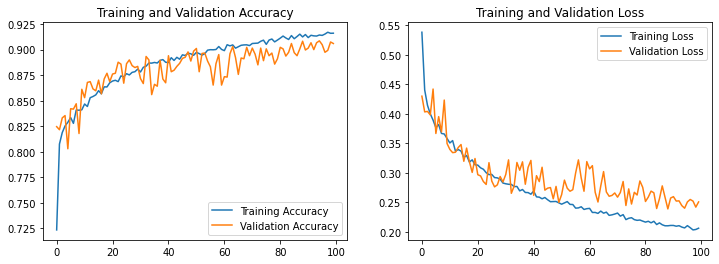

In [ ]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# define a function to plot the confusion matrix
def plot_cm(labels, predictions):
    
    # gernerate the confusion matrix
    conf_numpy = confusion_matrix(labels, predictions)
    # trasform the matrix to DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('confusion matrix',fontsize=15)
    plt.ylabel('real value',fontsize=14)
    plt.xlabel('prediction',fontsize=14)

In [ ]:
val_pre   = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        # need to increase one dimension for the image
        img_array = tf.expand_dims(image, 0) 

        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

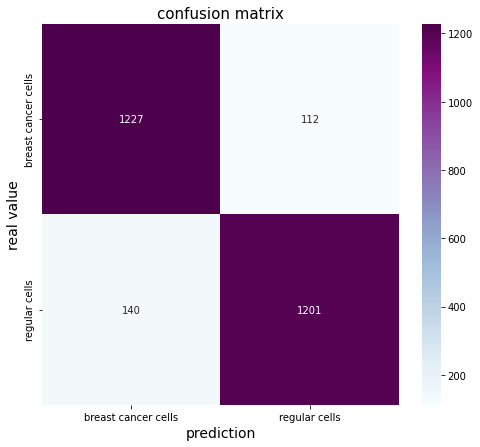

In [ ]:
plot_cm(val_label, val_pre)

#Analysis

In [ ]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names)) 
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])
    
test_accuracy_report(model)

                     precision    recall  f1-score   support

breast cancer cells       0.90      0.92      0.91      1339
      regular cells       0.91      0.90      0.91      1341

           accuracy                           0.91      2680
          macro avg       0.91      0.91      0.91      2680
       weighted avg       0.91      0.91      0.91      2680

Loss function: 0.2507432699203491, accuracy: 0.9059701561927795


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from keras.callbacks import ReduceLROnPlateau

model2 = Sequential()
model2.add(Conv2D(16, kernel_size = (3,3), input_shape = (50, 50, 3), activation = 'relu', padding = 'same'))
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
#
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
#
model2.add(MaxPool2D(pool_size = (2,2)))

model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
#
model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model2.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model2.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#
model2.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model2.add(Flatten())

model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
#
model2.add(Dense(16, activation='relu'))
#
model2.add(Dense(7, activation='softmax'))


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

model2.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
              metrics = ['accuracy'])

print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 50, 50, 16)        448       
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 conv2d_26 (Conv2D)          (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 23, 23, 32)        9248      
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 64)        18496     
                                                      

In [28]:
train_model  = model2.fit(train_ds,
                  epochs=20,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[learning_rate_reduction])

Epoch 1/20
671/671 [==============================] - 288s 428ms/step - loss: 0.7175 - accuracy: 0.5326 - val_loss: 0.6199 - val_accuracy: 0.7149 - lr: 7.5000e-04
Epoch 2/20
671/671 [==============================] - 287s 427ms/step - loss: 0.6395 - accuracy: 0.6497 - val_loss: 0.7647 - val_accuracy: 0.7131 - lr: 7.5000e-04
Epoch 3/20
671/671 [==============================] - 288s 429ms/step - loss: 0.5395 - accuracy: 0.7381 - val_loss: 0.4667 - val_accuracy: 0.8034 - lr: 7.5000e-04
Epoch 4/20
671/671 [==============================] - 281s 418ms/step - loss: 0.4719 - accuracy: 0.7920 - val_loss: 0.4161 - val_accuracy: 0.8295 - lr: 7.5000e-04
Epoch 5/20
671/671 [==============================] - 284s 423ms/step - loss: 0.4362 - accuracy: 0.8078 - val_loss: 0.3651 - val_accuracy: 0.8481 - lr: 7.5000e-04
Epoch 6/20
671/671 [==============================] - 286s 427ms/step - loss: 0.4104 - accuracy: 0.8212 - val_loss: 0.3753 - val_accuracy: 0.8414 - lr: 7.5000e-04
Epoch 7/20
671/671 [==

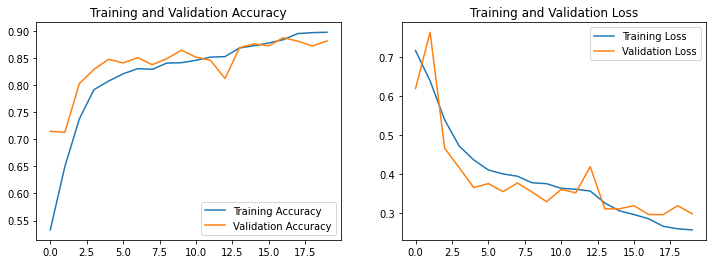

In [29]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
val_pre   = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        # need to increase one dimension for the image
        img_array = tf.expand_dims(image, 0) 

        prediction = model2.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

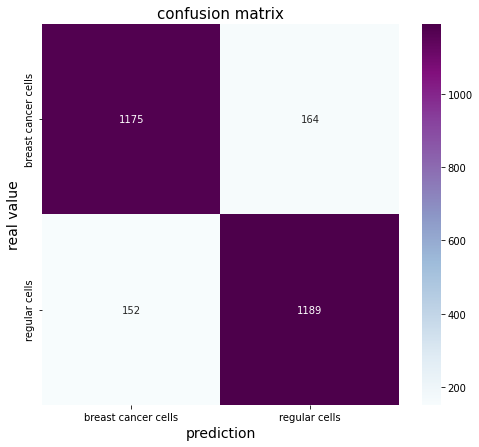

In [32]:
plot_cm(val_label, val_pre)

In [33]:
test_accuracy_report(model2)

                     precision    recall  f1-score   support

breast cancer cells       0.89      0.88      0.88      1339
      regular cells       0.88      0.89      0.88      1341

           accuracy                           0.88      2680
          macro avg       0.88      0.88      0.88      2680
       weighted avg       0.88      0.88      0.88      2680

Loss function: 0.2976979911327362, accuracy: 0.8820895552635193


#Conclusion 
Both model do a good job, however model1 has fewer layers and fewer paramters with droupout to prevent overfitting. \
And model2 have more layers and parameters but seems to perform less.\
I think the reasons are:\
1.degrade might happen
2.too much parameters may cause the model more lilkely to fall into local minimum\
3.with no dropout layer\
And what's more important is that model2 took too much time to train and the gain is small.